In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
from skimage import io

import pickle
import cv2

In [2]:
imgs = []
for i in range(2):
    img = cv2.imread(f'im{i}.png', flags=cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (min(img.shape[0], 500), min(img.shape[1], 500)))
    imgs.append(img)

img.shape

(500, 463)

Text(0.5, 1.0, 'Image 0')

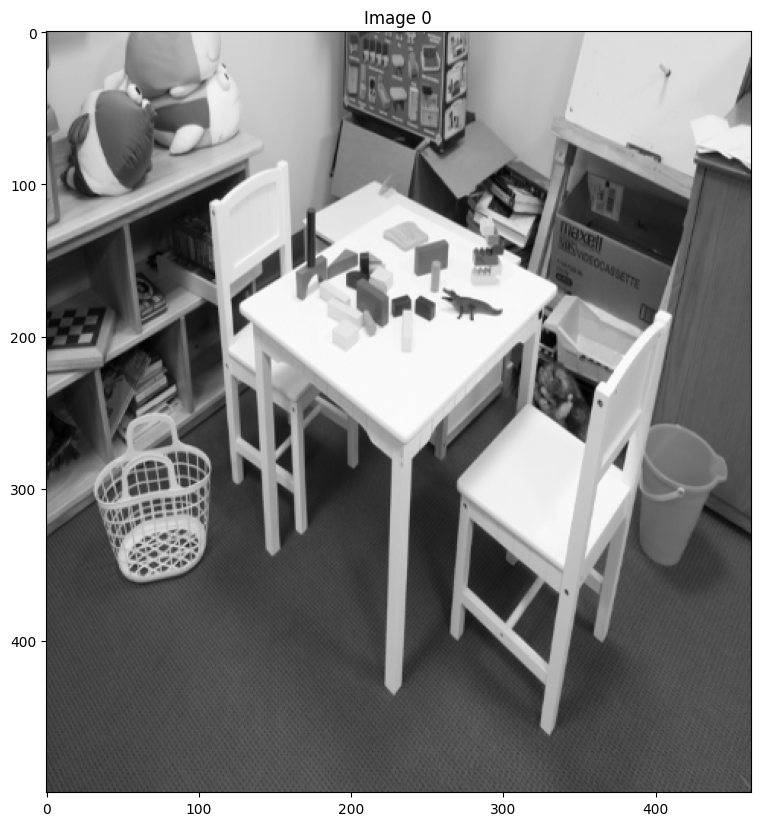

In [3]:
fig = plt.figure(figsize=(20, 20))
plt.subplot(1,2,1)
plt.imshow(imgs[0], cmap='gray')
plt.title('Image 0')

In [4]:
def corner_detect(image, n_corners, smooth_std, window_size):
    """
    Detect corners on a given image

    Args:
        image: 2D grayscale image on which to detect corners
        n_corners: Total number of corners to be extracted
        smooth_std: Standard deviation of the Gaussian smoothing kernel
        window_size: Window size for Gaussian smoothing kernel,
                     corner detection, and nonmaximum suppresion

    Returns:
        minor_eig_image: The minor eigenvalue image (same shape as image)
        corners: Detected corners (in x-y coordinates) in a numpy array of shape (n_corners, 2)
    """
    # Smooth the image
    smoothed = gaussian_filter(image, sigma=smooth_std)

    # Compute gradients using Sobel operators
    k_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=float)
    k_y = k_x.T
    g_x = convolve2d(smoothed, k_x, mode='same', boundary='symm')
    g_y = convolve2d(smoothed, k_y, mode='same', boundary='symm')

    # Compute the squares of the gradients and their product
    I_x_2 = g_x**2
    I_y_2 = g_y**2
    I_x_y = g_x * g_y

    # Allocate the minor eigenvalue image
    minor_eig_image = np.zeros_like(image, dtype=float)

    # Compute the structure tensor for each pixel (or in a window around it) and its eigenvalues
    half_win = window_size // 2
    for i in range(half_win, image.shape[0] - half_win):
        for j in range(half_win, image.shape[1] - half_win):
            # Compute sums within the window
            S_xx = np.sum(I_x_2[i-half_win:i+half_win+1, j-half_win:j+half_win+1])
            S_yy = np.sum(I_y_2[i-half_win:i+half_win+1, j-half_win:j+half_win+1])
            S_xy = np.sum(I_x_y[i-half_win:i+half_win+1, j-half_win:j+half_win+1])
            
            # Structure tensor
            M = np.array([[S_xx, S_xy], [S_xy, S_yy]])
            
            # Eigenvalues
            eigenvalues = np.linalg.eigvalsh(M)
            minor_eig_image[i, j] = np.min(eigenvalues)


            
    def nonmax_suppression(image, window_size):
        padded = np.pad(image, ((window_size//2, window_size//2), (window_size//2, window_size//2)), mode='constant', constant_values=np.min(image))
        suppressed = np.zeros_like(image)
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                local_window = padded[i:i+window_size, j:j+window_size]
                if image[i, j] == np.max(local_window):
                    suppressed[i, j] = image[i, j]
        return suppressed

    suppressed_image = nonmax_suppression(minor_eig_image, window_size)
    corner_indices = np.argpartition(-suppressed_image.ravel(), n_corners)[:n_corners]
    y, x = np.unravel_index(corner_indices, suppressed_image.shape)
    corners = np.column_stack((x, y))

    return minor_eig_image, corners


In [5]:
def show_eigen_images(imgs):
    print("Minor Eigen value images")
    fig = plt.figure(figsize=(20, 20))
    # Plot image 1
    plt.subplot(1,2,1)
    plt.imshow(imgs[0], cmap='gray')
    plt.title('Image 1')

    # Plot image 2
    plt.subplot(1,2,2)
    plt.imshow(imgs[1], cmap='gray')
    plt.title('Image 2')
    
    plt.show()

def show_corners_result(imgs, corners, window_size):
    print("Detected Corners")
    fig = plt.figure(figsize=(20, 20))
    ax1 = fig.add_subplot(221)
    ax1.imshow(imgs[0], cmap='gray')
    ax1.scatter(corners[0][:, 0], corners[0][:, 1], s=25, edgecolors='r', facecolors='none')
    ax1.title.set_text("Image 0")

    ax2 = fig.add_subplot(222)
    ax2.imshow(imgs[1], cmap='gray')
    ax2.scatter(corners[1][:, 0], corners[1][:, 1], s=25, edgecolors='r', facecolors='none')
    ax2.title.set_text("Image 1")
    
    plt.show()

Minor Eigen value images


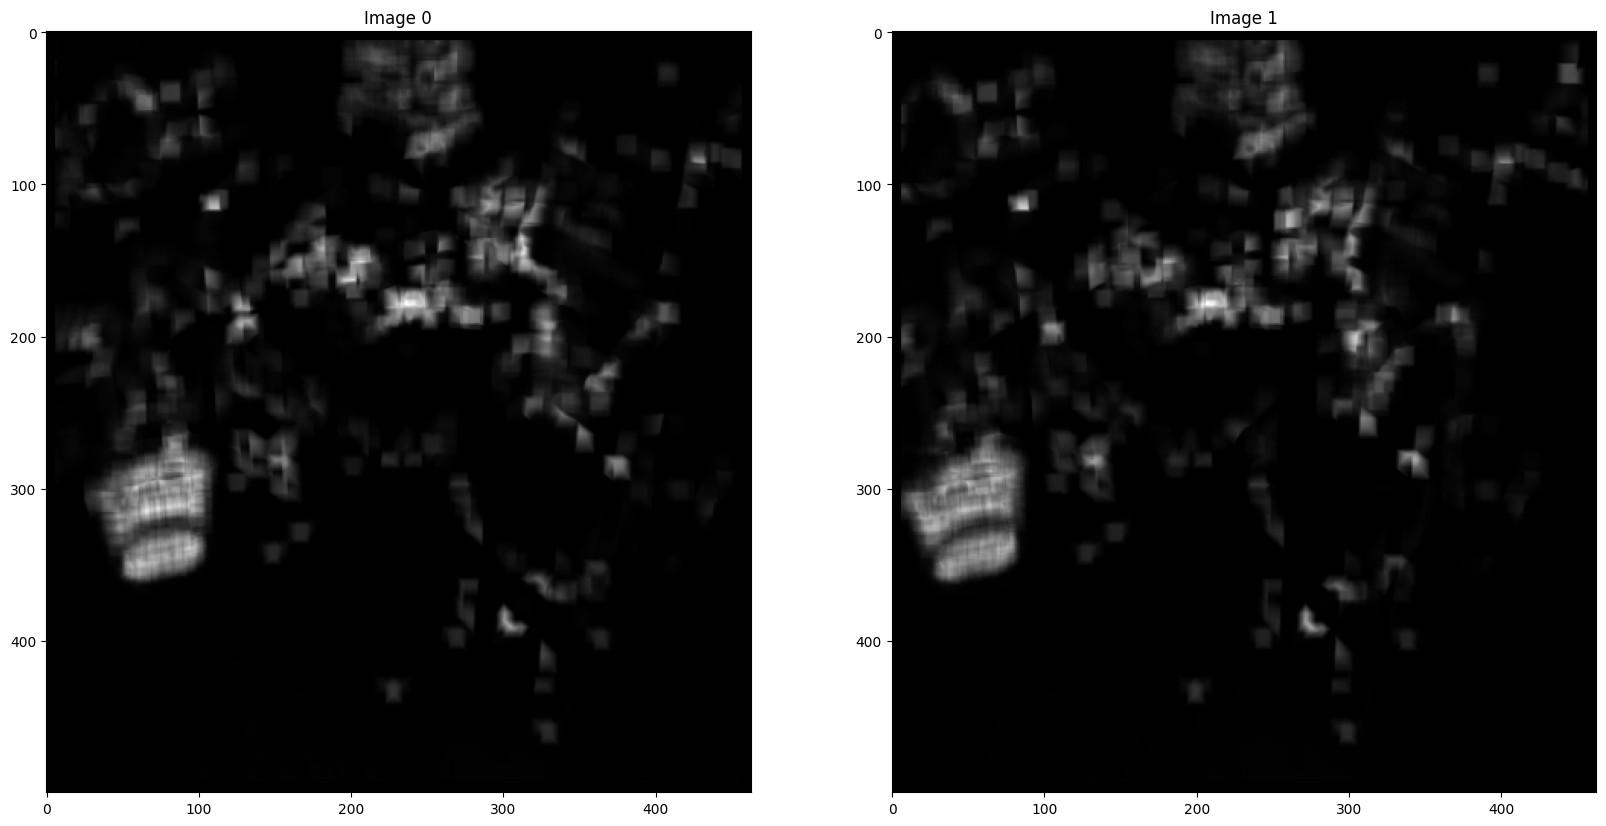

Detected Corners


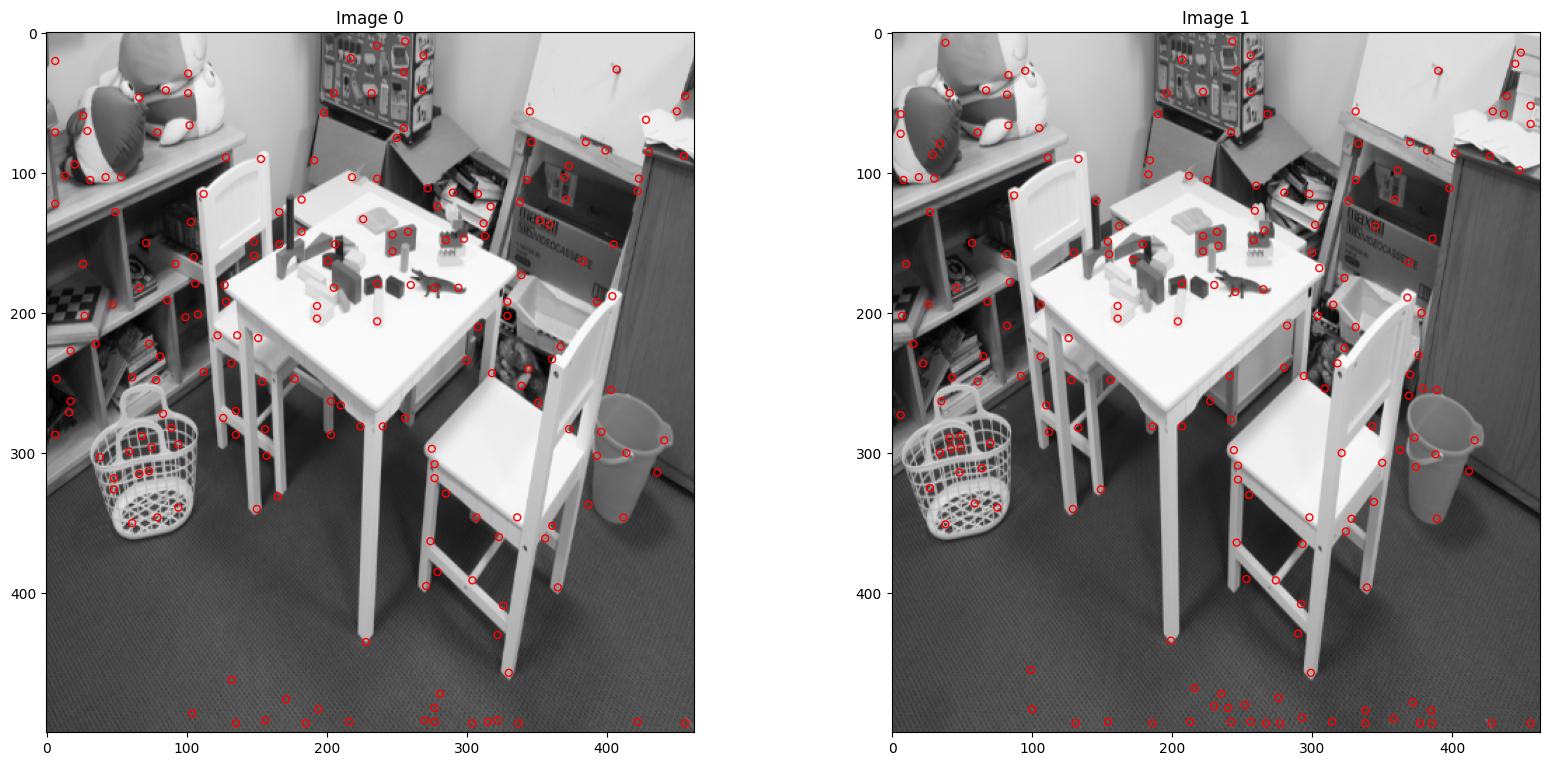

In [6]:
# Detect corners on the two provided images

# You may want to change these parameters accordingly
n_corners = 200
smooth_std = .1
window_size = 13

# Read images and detect corners on images
imgs = []
eig_imgs = []
corners = []
for i in range(2):
    img = cv2.imread(f'im{i}.png', flags=cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (min(img.shape[0], 500), min(img.shape[1], 500)))
    imgs.append(img)
    #img = io.imread('im' + str(i) + '.png')
    minor_eig_image, corners_vals = corner_detect(imgs[-1], n_corners, smooth_std, window_size)
    eig_imgs.append(minor_eig_image)
    corners.append(corners_vals)

# Show the results
# This may take a few seconds to run
show_eigen_images(eig_imgs)
show_corners_result(imgs, corners, window_size)

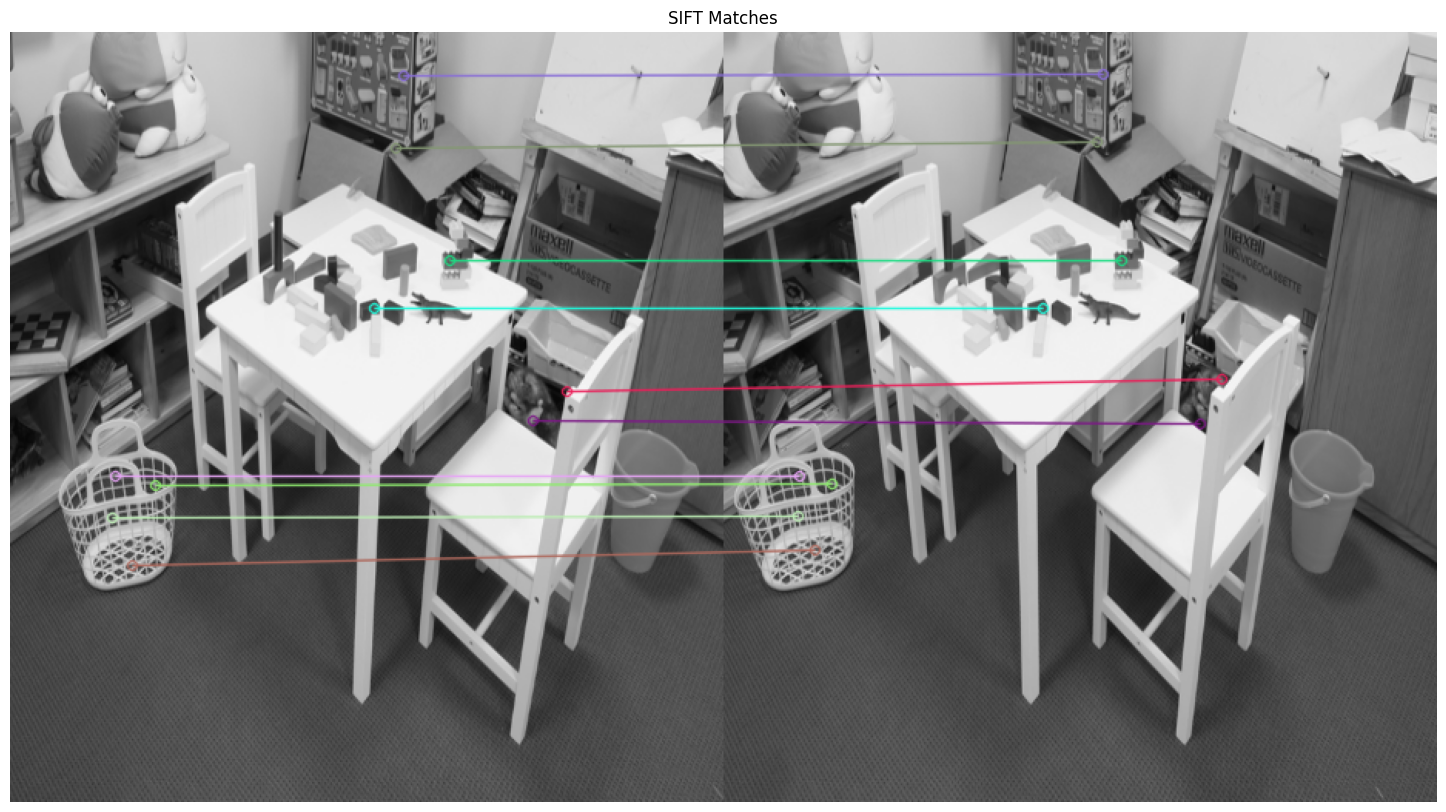

In [7]:

# Convert detected corners to keypoints for SIFT descriptor computation
kp1 = [cv2.KeyPoint(x=float(corner[0]), y=float(corner[1]), size=20) for corner in corners[0]]
kp2 = [cv2.KeyPoint(x=float(corner[0]), y=float(corner[1]), size=20) for corner in corners[1]]


sift = cv2.SIFT_create()


_, des1 = sift.compute(imgs[0], kp1)
_, des2 = sift.compute(imgs[1], kp2)

# Match descriptors using Brute Force Matcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches = bf.knnMatch(des1, des2, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 100 * n.distance:
        good_matches.append(m)


result = cv2.drawMatches(imgs[0], kp1, imgs[1], kp2, good_matches[:10], None, flags = 2)
    
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('SIFT Matches')
plt.axis('off')
plt.show()

In [8]:
# Extract location of good matches
print(len(matches))
points1 = np.zeros((len(good_matches), 2), dtype=np.float32)
points2 = np.zeros((len(good_matches), 2), dtype=np.float32)

for i, match in enumerate(good_matches):
    points1[i, :] = kp1[match.queryIdx].pt
    points2[i, :] = kp2[match.trainIdx].pt


H, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

200


In [9]:
points1

array([[ 68., 288.],
       [ 79., 346.],
       [339., 252.],
       [361., 233.],
       [ 94., 294.],
       [255.,  28.],
       [236., 179.],
       [250.,  75.],
       [ 66., 315.],
       [285., 148.],
       [ 73., 313.],
       [430.,  85.],
       [105., 160.],
       [ 48., 326.],
       [279., 124.],
       [ 59., 299.],
       [373., 283.],
       [ 94., 339.],
       [312., 136.],
       [339., 173.],
       [ 75., 296.],
       [128., 192.],
       [313., 145.],
       [ 89., 282.],
       [277., 182.],
       [ 66.,  46.],
       [329., 192.],
       [304., 391.],
       [206., 151.],
       [247., 156.],
       [166., 151.],
       [290., 114.],
       [ 48., 318.],
       [127., 180.],
       [156., 283.],
       [255.,  68.],
       [317., 124.],
       [323., 360.],
       [258., 142.],
       [268.,  41.],
       [269.,  16.],
       [112., 115.],
       [201., 163.],
       [351., 264.],
       [182., 142.],
       [260., 180.],
       [367., 224.],
       [298.,

In [10]:
imgs = []
for i in range(2):
    img = cv2.imread(f'im{i}.png')
    img = cv2.resize(img, (min(img.shape[0], 500), min(img.shape[1], 500)))
    imgs.append(img)

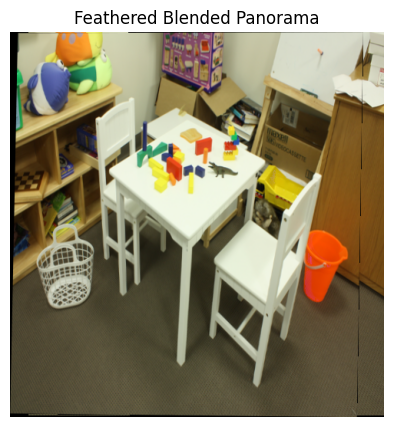

In [11]:
# Calculate size of the output panorama
height1, width1 = imgs[0].shape[:2]
height2, width2 = imgs[1].shape[:2]

# Corners of img1
corners1 = np.array([[0, 0], [0, height1], [width1, height1], [width1, 0]], dtype=np.float32).reshape(-1, 1, 2)

# Warp corners of img1 to the panorama coordinate system
corners1_warped = cv2.perspectiveTransform(corners1, H)

# Corners of img2 in panorama coordinate system
corners2 = np.array([[0, 0], [0, height2], [width2, height2], [width2, 0]], dtype=np.float32).reshape(-1, 1, 2)

# Combine corners of both images and find the minimum and maximum points
all_corners = np.concatenate((corners1_warped, corners2), axis=0)
[x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
[x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

# Shift the transformation to deal with the negative offset
translate_dist = [-x_min, -y_min]
H_translation = np.array([[1, 0, translate_dist[0]], [0, 1, translate_dist[1]], [0, 0, 1]]) # Translation matrix

# Use warpPerspective to transform img1 with the combined homography
img1_warped = cv2.warpPerspective(imgs[0], H_translation.dot(H), (x_max-x_min, y_max-y_min))

# Use the translation to place img2 in the stitched panorama
img2_placement = img1_warped.copy()
img2_placement[translate_dist[1]:translate_dist[1]+height2, translate_dist[0]:translate_dist[0]+width2] = imgs[1]


overlap_width = translate_dist[0] + width2 - (x_max - x_min)

if overlap_width > 0:  # Check if there's an actual overlap
    # Step 2: Create a feathering mask for the overlap region
    # The mask values will linearly decrease from 1 to 0 across the overlap width
    feathering_mask = np.tile(np.linspace(1, 0, overlap_width), (height2, 1)).astype(np.float32)
    
    # Step 3: Apply the feathering mask to both images in the overlap area
    # For img1_warped
    img1_overlap_area = img1_warped[translate_dist[1]:translate_dist[1]+height2, translate_dist[0]:translate_dist[0]+overlap_width]
    img1_warped[translate_dist[1]:translate_dist[1]+height2, translate_dist[0]:translate_dist[0]+overlap_width] = img1_overlap_area * feathering_mask
    
    # For img2 in img2_placement
    img2_overlap_area = img2_placement[translate_dist[1]:translate_dist[1]+height2, translate_dist[0]:translate_dist[0]+overlap_width]
    img2_placement[translate_dist[1]:translate_dist[1]+height2, translate_dist[0]:translate_dist[0]+overlap_width] = img2_overlap_area * (1 - feathering_mask)

# Combine the images with feathering applied
img2_placement[translate_dist[1]:translate_dist[1]+height2, translate_dist[0]:translate_dist[0]+width2] = imgs[1]

# Final blend: Combine img1_warped and img2_placement with feathering
# Note: This step is crucial as it combines the modified img1_warped with the already placed img2
final_blended_panorama = np.where(img1_warped > 0, img1_warped, img2_placement)

# Display the final stitched and blended image
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(final_blended_panorama, cv2.COLOR_BGR2RGB))
plt.imsave('panoramic.png', final_blended_panorama)
plt.title('Feathered Blended Panorama')
plt.axis('off')
plt.show()

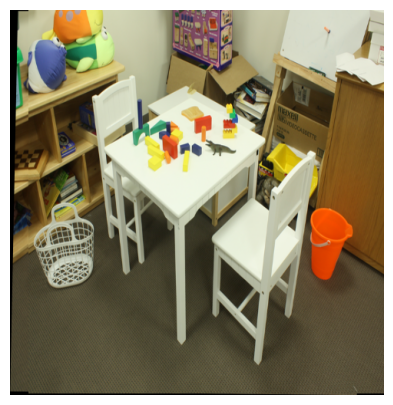

In [15]:


# Function to calculate output size and offset
def calculate_size_and_offset(H, img1, img2):
    # Get dimensions of the images
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    
    # Corners of img1
    corners1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    
    # Transform corners of img1 using H
    transformed_corners1 = cv2.perspectiveTransform(corners1, H)
    
    # Corners of img2
    corners2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    
    # All corners together
    all_corners = np.concatenate((transformed_corners1, corners2), axis=0)
    
    # Find min and max extents
    [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)
    
    # Translate everything so that min x, y are 0, 0
    translate_dist = [-x_min, -y_min]
    
    # Output width and height
    output_width = x_max - x_min
    output_height = y_max - y_min
    
    return output_width, output_height, translate_dist

# Calculate size and offset
output_width, output_height, translate_dist = calculate_size_and_offset(H, imgs[0], imgs[1])

# Translation matrix
translate_H = np.array([[1, 0, translate_dist[0]], [0, 1, translate_dist[1]], [0, 0, 1]])

# Warp img1 with the new dimensions and translation
warped_img1 = cv2.warpPerspective(imgs[0], translate_H.dot(H), (output_width, output_height))

# Initialize output image with warped img1
output_image = warped_img1.copy()

# Place img2 in the output image, adjusting for the translation
output_image[translate_dist[1]:translate_dist[1]+imgs[1].shape[0], translate_dist[0]:translate_dist[0]+imgs[1].shape[1]] = imgs[1]

# Show result
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.imsave('panoramic.png', cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
